In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib 
import astropy.units as u
from astropy.io import fits
from astropy.constants import m_p, M_sun

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
#from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_MRN77_force_reg import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
wid = "W0204-0506"

In [4]:
#Load the properties of the BHDs
op = ObjectProperties([wid])

In [5]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [6]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra([wid])

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [7]:
#Read the MRN77 chi2 map. 
p_map = dict()
chi2_map = dict()
pw = LoadSKIRTOR_MRN77(cone_type='Bottom', interp_method='slinear')

bands_use = list()
p_meas = list()
p_unc = list()
for band in op.pfrac[wid].keys():
    bands_use.append(bands.bp[band])
    p_meas.append(op.pfrac[wid][band])
    p_unc.append(op.epfrac[wid][band])

fname = "maps_BottomCone/chi2_map_{}.fits".format(wid)
h = fits.open(fname)
tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
chi2_map[wid] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
chi2_map[wid][:,:,:] = h[0].data
chi2_map[wid].mask = h[1].data.astype(bool)
print(wid, chi2_map[wid][0,0,0])

W0204-0506 1402.8429752066115


In [8]:
#Find the best solution for W0204-0506
i, j, k = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid].min())

50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08


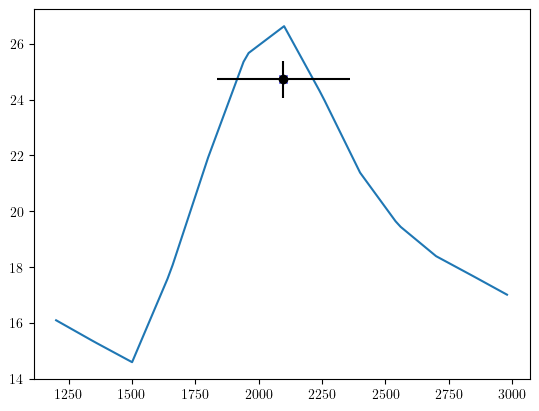

In [9]:
lam_grid = np.arange(1200., 3000., 20.)*u.AA
plt.plot(lam_grid, 100*pw.p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)))

for bname in op.pfrac[wid].keys():
    plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

    #p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i]], [cang_grid[j]], [iang_grid[k]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    #plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')
    p_mod = pw.p_bb(bands.bp[bname], tang_grid[i:i+1], cang_grid[j:j+1], iang_grid[k:k+1], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

In [10]:
#Set the additional SKIRTOR models we want to plot for W0204-0506
other_sk_models = [
    {"d03_mod":"MW"},
    {"d03_mod":"LMC"},
    {"d03_mod":"SMC"},
    #{"gs_min":0.005, "gs_max":0.25, "a":3.5},
    {"gs_min":1, "gs_max":10, "a":3.5, "sil":True},
    #{"gs_min":0.1, "gs_max":1, "a":0.0},
    #{"gs_min":0.1, "gs_max":1, "a":3.5},
    #{"gs_min":0.1, "gs_max":1, "a":3.5, "sil":True},
    {"gs_min":0.005, "gs_max":0.25, "a":3.5, "sil":True},
]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    other_sk.append(LoadSKIRTOR_General(**oskm))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)


In [11]:
np.argwhere(chi2_map[wid]<3.).shape, chi2_map[wid].shape

((15090, 3), (71, 91, 131))

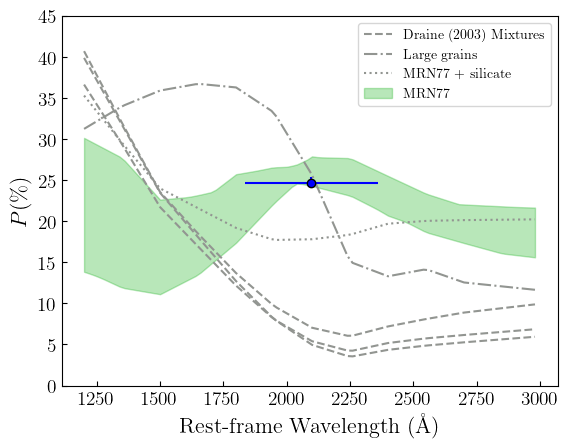

In [12]:
fig, ax = plt.subplots(1)#, figsize=(10,4))
plt.subplots_adjust(wspace=0., hspace=0.)

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

lam_grid = np.arange(1200., 3000., 20.)*u.AA

#labels = ['Draine (2003) Mixtures', None, None, 'Small grains graphite only', 'Large grains', 'MRN77 + silicate']
labels = ['Draine (2003) Mixtures', None, None, 'Large grains', 'MRN77 + silicate']
for mm, osk in enumerate(other_sk):
    kk = np.argmin(other_chi2[mm])
    ls = 'dashed'
    if mm==3:
        ls = 'dashdot'
    #elif mm==4:
    #    ls = (5, (10,3))
    # if mm>2 and mm<5:
    #     ls = 'dashdot'
    elif mm==4:
        ls = 'dotted'
    ax.plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=ls, label=labels[mm])
    
#i1, j1, k1 = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
#ax.plot(lam_grid, 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:green',ls='solid', label='MRN77')

min_curve = np.zeros(len(lam_grid)) + 1e32
max_curve = np.zeros(len(lam_grid))
for ind in np.argwhere(chi2_map[wid]<1.0):
    i1, j1, k1 = ind
    curve = 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid))
    min_curve = np.where(curve<min_curve, curve, min_curve)
    max_curve = np.where(curve>max_curve, curve, max_curve)
    #ax.plot(lam_grid, 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:green',ls='solid', alpha=0.1)#, label='MRN77')
ax.fill_between(lam_grid.value, min_curve, max_curve, color='xkcd:green', alpha=0.3, label='MRN77')

for bname in op.pfrac[wid].keys():

    ax.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c='blue', markeredgecolor='black')

    #p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i1]], [cang_grid[j1]], [iang_grid[k1]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    #ax.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], c='blue', marker='x')

# ax.text(0.05, 0.9, "{} Best-fit".format(wid), transform=ax.transAxes, fontsize=16, weight='bold')
# ax.text(0.05, 0.82, r"$\psi_{{\rm Torus}} = {:.0f}^{{\circ}}$".format(tang_grid[i1].value), transform=ax.transAxes, fontsize=14)
# ax.text(0.05, 0.74, r"$\psi_{{\rm Cone}}  = {:.0f}^{{\circ}}$".format(cang_grid[j1].value), transform=ax.transAxes, fontsize=14)
# ax.text(0.05, 0.66, r"$\eta = {:.0f}^{{\circ}}$".format(iang_grid[k1].value), transform=ax.transAxes, fontsize=14)

ax.legend()#loc=(0.67, 0.7))

ax.set_ylim([0., 45.])

ax.set_ylabel(r"$P (\%)$", fontsize=16)
ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$", fontsize=16)

fig.savefig("SKIRTOR_W0204.png", dpi=200, bbox_inches='tight')


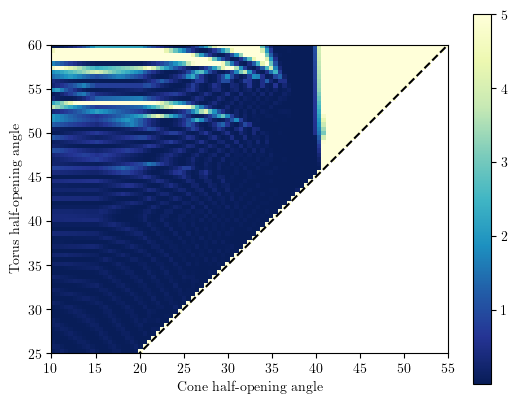

In [13]:
chi2_aux = np.min(chi2_map[wid], axis=2)
for i, tang in enumerate(tang_grid):
    for j, cang in enumerate(cang_grid):
        if cang+5*u.deg > tang:
            chi2_aux[i,j] = np.nan
cmap = 'YlGnBu_r'
#cmap = 'gray'
cb = plt.imshow(chi2_aux, origin='lower', vmax=5., cmap=cmap, extent=[np.min(cang_grid.value), np.max(cang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(plt.xlim(), np.array(plt.xlim())+5, 'k--') 
plt.xlabel("Cone half-opening angle")
plt.ylabel("Torus half-opening angle")
plt.colorbar(cb)

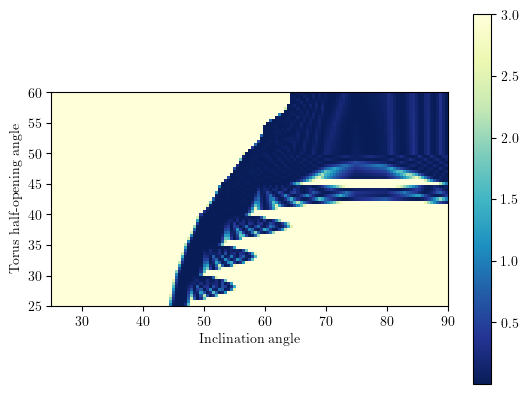

In [14]:
cb = plt.imshow(np.min(chi2_map[wid], axis=1), origin='lower', vmax=3., cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Torus half-opening angle")
plt.colorbar(cb)

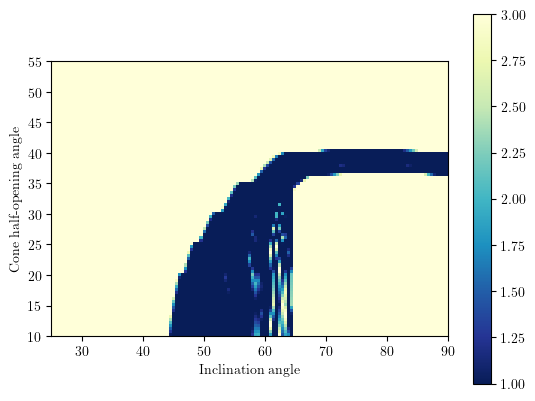

In [15]:
cb = plt.imshow(np.min(chi2_map[wid], axis=0), origin='lower', vmin=1.0, vmax=3., cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

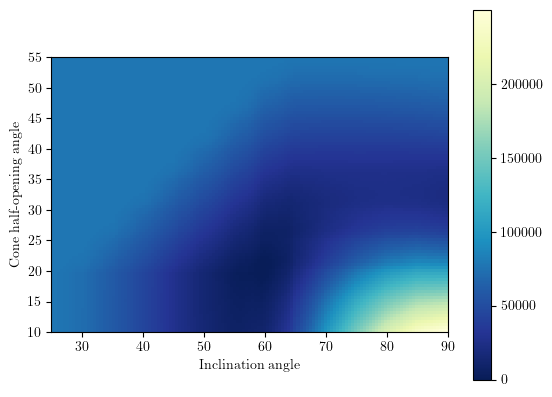

In [16]:
chi2_use = np.sum(chi2_map[wid], axis=0)
chi2_use -= np.min(chi2_use)
cb = plt.imshow(chi2_use, origin='lower', cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

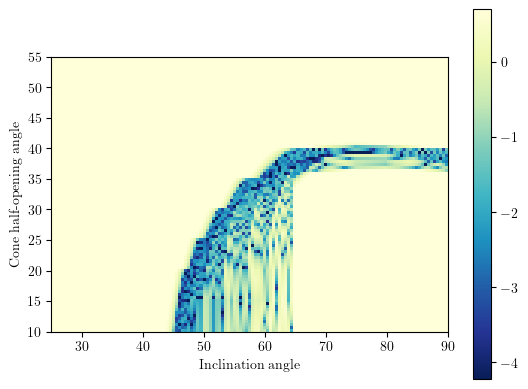

In [17]:
cb = plt.imshow(np.log10(np.min(chi2_map[wid], axis=0)), origin='lower', vmin=np.log10(6e-5), vmax=np.log10(5.), cmap='YlGnBu_r', extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
plt.xlabel("Inclination angle")
plt.ylabel("Cone half-opening angle")
plt.colorbar(cb)

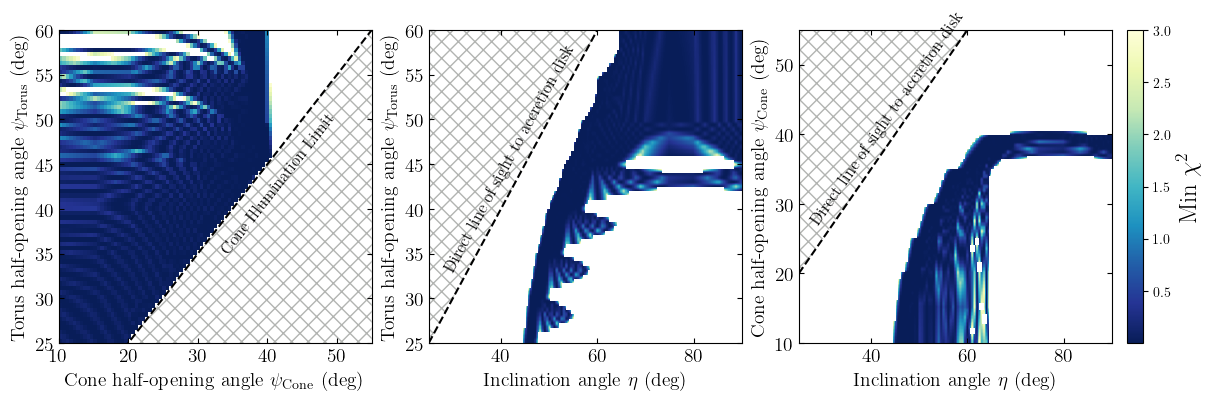

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), layout='constrained')
for ax in axs.flatten():
   #ax.tick_params(axis='both', which='major', labelsize=14)
   #ax.tick_params(axis='both', which='minor', labelsize=12)
   ax.tick_params(axis='both', direction='in', labelsize=14, bottom=True, top=True, left=True, right=True)
#    ax.set_aspect('auto')

vmin = np.min(chi2_map[wid])
vmax = 3.0
cmap = 'YlGnBu_r'
#cmap = 'gray'

axis_label_fontsize = 14

chi2_use = np.ma.zeros(chi2_map[wid].shape)
chi2_use.mask = np.zeros(chi2_use.shape, dtype=bool)
chi2_use[:,:,:] = np.copy(chi2_map[wid])
II, JJ, KK = np.meshgrid(tang_grid.value, cang_grid.value, iang_grid.value, indexing='ij')
chi2_use.mask[(JJ+5>II) | (KK<II)] = True
#chi2_use.mask[(JJ+10>II) | (II>KK)] = True
#chi2_use.mask[(JJ+15>II) | (II>KK)] = True
chi2_use.mask[chi2_use>vmax] = True

#Torus - Cone
ax = axs[0]
chi2_aux = np.min(chi2_use, axis=2)
cb = ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(cang_grid.value), np.max(cang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())+5, 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())+5, ax.get_ylim()[0], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(33, 35, "Cone Illumination Limit", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Torus - Inclination
ax = axs[1]
chi2_aux = np.min(chi2_use, axis=1)
ax.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(tang_grid.value), np.max(tang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim()), ax.get_ylim()[1], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
ax.set_xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
ax.set_ylabel(r"Torus half-opening angle $\psi_{\rm Torus}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(28, 33, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

#Cone - Inclination
ax = axs[2]
chi2_aux = np.min(chi2_use, axis=0)
cb = plt.imshow(chi2_aux, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=[np.min(iang_grid.value), np.max(iang_grid.value), np.min(cang_grid.value), np.max(cang_grid.value)])
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())-5, 'k--') 
ax.fill_between(ax.get_xlim(), np.array(ax.get_xlim())-5, ax.get_ylim()[1], color="none", hatch="xx", edgecolor="xkcd:gray", linewidth=0.0, alpha=0.7)
plt.xlabel(r"Inclination angle $\eta$ (deg)", fontsize=axis_label_fontsize)
plt.ylabel(r"Cone half-opening angle $\psi_{\rm Cone}$ (deg)", fontsize=axis_label_fontsize)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.text(27, 27, "Direct line of sight to accretion disk", rotation=np.arctan2(abs(x1-x0), abs(y1-y0))*180/np.pi, fontsize=12, weight='extra bold', fontfamily='sans-serif')

fig.colorbar(cb, fraction=0.05).set_label(label=r'Min $\chi^2$',size=18)

plt.show()
fig.savefig("W0204_chi2maps.png", dpi=200, bbox_inches='tight')

In [19]:
#Gas mass estimate for the best-fit cone with the MRN77 dust. 
i, j, k = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map[wid].min())

tau_V = 0.1
delta_psi_c = 10*u.deg #10*u.deg
psi_c = np.array([10, 38, 40])*u.deg #cang_grid[j]
X = 1.5e-23*u.cm**2
L = 10*u.kpc
Rv = 3.1

Mg = (2.5/np.log(10.)) * np.pi/3. * m_p * tau_V/(X*Rv) * L**2 * np.cos(psi_c-delta_psi_c/2.)*(np.tan(psi_c))**2
print((Mg/M_sun).to(u.dimensionless_unscaled)/1e9)

#Now the obscuration of a light ray going through the dusty section of the cone at mid-height
d = 0.5*L*(np.tan(psi_c)-np.tan(psi_c-delta_psi_c))
n_H = (2.5/np.log(10.)) * tau_V/(X*Rv) * np.cos(psi_c-delta_psi_c/2.)/L
print(d, n_H.to(u.cm**-3), X*n_H*d)


50.0 deg 35.5 deg 61.0 deg 1.4407787221813311e-08
[0.06065613 1.00254534 1.12949556]
[0.8816349  1.24788097 1.30874681] kpc [0.07538155 0.06346178 0.06198482] 1 / cm3 [0.00307607 0.00366545 0.00375477]


In [20]:
m_p.__dict__

{'_abbrev': 'm_p',
 '_name': 'Proton mass',
 '_value': 1.67262192369e-27,
 '_unit_string': 'kg',
 '_uncertainty': 5.1e-37,
 '_reference': 'CODATA 2018',
 '_system': None,
 '_checked_units': True,
 '_unit': Unit("kg")}

In [21]:
616. / np.cos(60*u.deg), 616. / np.cos(80*u.deg)

(<Quantity 1232.>, <Quantity 3547.40261762>)